# Hyper-parameter Optimization with RayTune + RAPIDS

### Introduction

&emsp; &emsp; &emsp; [Hyperparameter optimization](https://cloud.google.com/ai-platform/training/docs/hyperparameter-tuning-overview) is the task of picking the values for the hyperparameters of the model that provide the optimal results for the problem, as measured on a specific test dataset. This is often a crucial step and can help boost the model accuracy when done correctly. Despite its theoretical importance, HPO has been difficult to implement in practical applications because of the resources needed to run so many distinct training jobs. With RayTune + cuML, we want to attempt to bridge that gap and make HPO more practical and easy to use.

#### What is RayTune?

&emsp; &emsp; &emsp; [RayTune](https://ray.readthedocs.io/en/latest/index.html) is a scalable Hyperparameter optimization library. It allows distributed HPO, provides various [search algorithms](https://ray.readthedocs.io/en/latest/tune-searchalg.html) to allow different optimization techniques to be explored with ease. The library also provides [scheduling algorithms](https://ray.readthedocs.io/en/latest/tune-schedulers.html) that allows a smarter way to schedule the different parameter sweep instead of the basic First In-First Out method which is followed by other libraries(Scikit-Learn, Dask-ml) that support HPO. The different scheduling algorithms can make the HPO process resource efficient and help arrive at the best parameters much faster.

#### What is RAPIDS?

&emsp; &emsp; &emsp; The [RAPIDS](https://rapids.ai/start.html) framework provides a library suite that can execute end-to-end data science pipelines entirely on GPUs. One of the libraries in this framework is [cuML](https://docs.rapids.ai/api/cuml/stable/), which contains various ML algorithms that take advantage of GPU to run. You can learn more about RAPIDS [here](https://rapids.ai/about.html). 

For this demo, we will be using the [Airline dataset](http://kt.ijs.si/elena_ikonomovska/data.html). The aim of the problem is to predict the arrival delay. It has about 116 million entries with 13 attributes that are used to determine the delay for a given airline. In this notebook, we will demonstrate the use of a cuML [RandomForestClassifier](https://rapidsai.github.io/projects/cuml/en/0.12.0/api.html#cuml.ensemble.RandomForestClassifier) model with RayTune and try to understand how the HPO improves the performance, and make a case for why it is useful to perform.

Note: The notebook also includes the scikit-learn RandomForest for the CPU version - this should be used only for the performance comparison and is <b>not</b> recomended with large ranges.

Let's get started with the notebook!

In [1]:
import argparse
import logging
import math
import multiprocessing
import os
import sys
import time
from datetime import datetime
import cudf 
import cupy
import numpy as np
import pandas as pd
import ray
from ray import tune
from ray.tune import track, trial
from ray.tune.logger import TBXLogger
from ray.tune.schedulers import (ASHAScheduler, AsyncHyperBandScheduler, PopulationBasedTraining)
from ray.tune.utils import get_pinned_object, pin_in_object_store
import cuml
from cuml.preprocessing.model_selection import train_test_split

_DEBUG = bool(os.environ.get("_DEBUG", False))

## Parameter Ranges and Base Directory

We define the parameter ranges for the options that we want to explore. The larger the ranges, more likely we will find the "best" parameters - take into account the GPU memory constraints while deciding the ranges. For really large ranges and many trials (`num_samples`), there might be many failures during to memory issues.

The variable `base_dir` determines where the data will be stored. It is currently is set to use to directory the notebook is present in. You are welcome to change that if you want to.

`search_alg` and `sched_alg` are the options to change the search and scheduling algorithms. We discuss what these algorithms are later in the notebook.

In [2]:
base_dir = os.getcwd()

num_samples= 10
compute = "GPU" # Can take a CPU value (only for performance comparison. Not recommended)
CV_folds = 3 # The number of Cross-Validation folds to be performed
search_alg = "SkOpt"
sched_alg = "AsyncHyperBand"
num_rows = 5000000 # Select the number of rows to be considered in this notebook; maximum for the dataset is 115000000
max_concurrent = -1 # Optional for CPU option

# HPO Param ranges 
# NOTE: Depending on the GPU memory we might need to adjust the parameter range for a successful run
n_estimators_range = (50, 1000)
max_depth_range = (2, 18)
max_features_range = (0.1, 0.8)

hpo_ranges = {
    "n_estimators": n_estimators_range,
    "max_depth": max_depth_range,
    "max_features": max_features_range,
}

In [ ]:
# Ensure the dataset is setup
dataset_config = {
    'dataset_name': "airline",
    'nrows': num_rows,  # Max Rows in dataset: 115000000
    'delayed_threshold': 10,
    'remote_URL': 'http://kt.ijs.si/elena_ikonomovska/datasets/airline/airline_14col.data.bz2',
    'local_cache_dir': os.path.join(base_dir, "data"),
}

download_filename = os.path.join(dataset_config['local_cache_dir'], 
                                     os.path.basename(dataset_config['remote_URL']))    
decompressed_filename = os.path.splitext(download_filename)
orc_name = os.path.join(dataset_config['local_cache_dir'], "airline"+str(dataset_config["nrows"])+".orc")

data_dir = dataset_config['local_cache_dir']

## Prepare Dataset

This ensures that the dataset is present in the local directory specified in `dataset_config['local_cache_dir']`, if not, it downloads and places it in the directory. We will store a copy of the total dataset with `num_rows` as an ORC file for easier reading the next time we run the notebook. The path for the ORC file will be determined by `orc_name` specified in the previous cell.

In [3]:
def prepare_dataset():

    import cudf
    from urllib.request import urlretrieve
    import subprocess

    global download_filename, decompressed_filename, orc_name

    if os.path.isfile(orc_name):
        print(f' > File already exists. Ready to load at {orc_name}')
        return

    # Ensure folder exists
    os.makedirs(dataset_config['local_cache_dir'], exist_ok=True)

    # download progress tracker
    def data_progress_hook(block_number, read_size, total_filesize):
        if (block_number % 1000) == 0:
            print(f' > percent complete: { 100 * ( block_number * read_size ) / total_filesize:.2f}\r', end='')
        return

    if not os.path.exists(download_filename):
        print(f'File does not exist, downloading now...')
        urlretrieve(url=dataset_config['remote_URL'],
                filename= download_filename,
                reporthook=data_progress_hook)

        print(f' > Download complete {download_filename}')
    else:
        print(f'Dataset already downloaded')

    # Decompressing
    completed = subprocess.run(["bzip2", "-d", download_filename])
    print('returncode:', completed.returncode)

    input_cols = ["Year", "Month", "DayofMonth", "DayofWeek", "CRSDepTime", "CRSArrTime", "UniqueCarrier", "FlightNum", "ActualElapsedTime",
    "Origin", "Dest", "Distance", "Diverted", "ArrDelay"
    ]

    # ensure we respect bounds on rows [ airline max = 115 M ]
    nrows = np.min((dataset_config['nrows'], 115000000))

    pdf = pd.read_csv(decompressed_filename[0], names=input_cols, nrows=nrows)
    # turn into binary classification [i.e. flight delays beyond delayed_threshold minutes are considered late ]
    pdf["ArrDelayBinary"] = 1. * (pdf["ArrDelay"] > dataset_config['delayed_threshold'])

    # drop non-binary label column [ delay time ]
    pdf = pdf[pdf.columns.difference(["ArrDelay"])]

    # encode categoricals as numeric
    for col in pdf.select_dtypes(['object']).columns:
        pdf[col] = pdf[col].astype('category').cat.codes.astype(np.int32)

    # cast all columns to int32
    for col in pdf.columns:
        pdf[col] = pdf[col].astype(np.float32)  # needed for random forest

    # put target/label column first [ classic XGBoost standard ]
    output_cols = ["ArrDelayBinary"] + input_cols[:-1]
    
    pdf = pdf.reindex(columns=output_cols)
    cdf = cudf.DataFrame.from_pandas(pdf)
    cdf.to_orc(orc_name)
    return

## Utility Functions and Class

1. `get_trial_name`(function) : Generates the trial name over an iterator variable to store results.

2. `logunifrom`(function) : Custom implementation of `tune.loguniform` function because there was a problem with the default callable.

3. `PerfTimer`(class) : A high resolution timer class in order to support the timing of operations to report during the experiment runs.



In [4]:
trial_num = 0
def get_trial_name(trial: ray.tune.trial.Trial):
    # Returns the trial number over an iterator variable trail_num
    global trial_num
    trial_num = trial_num + 1
    trial_name = trial.trainable_name + "_" + str(trial_num)
    return trial_name

In [5]:
class PerfTimer:
    # High resolution timer for reporting training and inference time. 
    def __init__(self):
        self.start = None        
        self.duration = None        
    def __enter__(self):
        self.start = time.perf_counter()
        return self
    def __exit__(self, *args):        
        self.duration = time.perf_counter() - self.start

## Setting Up Tune

We will set up the Tune training with the [Trainable API](https://ray.readthedocs.io/en/latest/tune-usage.html#trainable-api) because it is stateful and allows checkpointing, which is useful for complex algorithms.

To do this, let's subclass the `tune.Trainable` class and define the functions for initial setup, training, saving and restoring the models.

### Member functions
1. `_setup` : Load the dataset and set the necessary parameters to config values (uses `_build`)

2. `_train` : Splitting the data into train and test sets, training a CPU or GPU model depending on `compute` mode. Evaluate the model and store the test accuracy. 

3. `_save` and `_restore` : Checkpoint the test accuracy periodically (specified by the scheduling algorithms)



In [6]:
class BaseTrainTransformer(tune.Trainable):
    @property
    def static_config(self) -> dict:
        return getattr(self, "_static_config", {})

    def _setup(self, config: dict):

        CSP_paths = {"train_data": data_dir}

        # ingest data [ post pre-processing ]
        if compute == "GPU":
            dataset = cudf.read_orc(orc_name)
        else:
            with open(orc_name, mode='rb') as file:
                dataset = pyarrow_orc.ORCFile(file).read().to_pandas()

        self._dataset, self._col_labels, self._y_label = dataset, None, "ArrDelayBinary"
        # classification objective requires int32 label for cuml random forest
        self._dataset[self._y_label] = self._dataset[self._y_label].astype('int32')
        self._build(config)

    def _build(self, new_config):
        self._model_params = {
            'max_depth': int(new_config["max_depth"]),
            'n_estimators': int(new_config["n_estimators"]),
            'max_features': float(new_config["max_features"]),
            'n_bins': 16,  #args.n_bins,
            'seed': time.time(),
        }
        self._global_best_model = None
        self._global_best_test_accuracy = 0

    def _train(self):

        iteration = getattr(self, "iteration", 0)
        # split data
        X_train, X_test, y_train, y_test = train_test_split( X = self._dataset, y = self._y_label, train_size = 0.8, 
                                                                          shuffle = True, random_state = iteration )  
        # train model
        if compute == "GPU":
            rf_model = cuml.ensemble.RandomForestClassifier ( n_estimators = self._model_params['n_estimators'],
                                                                max_depth = self._model_params['max_depth'],
                                                                n_bins = self._model_params['n_bins'],
                                                                max_features = self._model_params['max_features']) 
        elif compute == "CPU":
            # Optionally allow CPU version for performance comparison
            rf_model = sklearn.ensemble.RandomForestClassifier( n_estimators = self._model_params['n_estimators'],
                                                                max_depth = self._model_params['max_depth'],                                                                
                                                                max_features = self._model_params['max_features'], 
                                                                n_jobs = -1)
        else:
            print("Unknown option. Please select CPU or GPU")
            return
        
        with PerfTimer() as train_timer:
            trained_model = rf_model.fit( X_train, y_train)
        training_time = train_timer.duration
        
        # evaluate perf
        with PerfTimer() as inference_timer:
            test_accuracy = trained_model.score( X_test, y_test.astype('int32') )
        infer_time = inference_timer.duration
        
        
        # update best model [ assumes maximization of perf metric ]
        if test_accuracy > self._global_best_test_accuracy:
            self._global_best_test_accuracy = test_accuracy
            self._global_best_model = trained_model

        return {
            "test_accuracy": test_accuracy,
            "train_time": round(training_time, 4),
            "infer_time": round(infer_time, 4),
            "is_bad": not math.isfinite(test_accuracy),
        }

    def _save(self, checkpoint_dir):
        return {
            "test_accuracy": self._global_best_test_accuracy,
        }

    def _restore(self, checkpoint):
        self._global_best_test_accuracy = checkpoint["test_accuracy"]

    def reset_config(self, new_config):
        # Rebuild the config dependent stuff
        self._build(new_config)
        self.config = new_config
        return True

## Search Algorithm

This function enables us to select a search algorithm. These are the two options in available in this notebook:

### 1. [BayesOptSearch](https://ray.readthedocs.io/en/latest/tune-searchalg.html#bayesopt-search) 

This is backed by [bayesian optimization](https://github.com/fmfn/BayesianOptimization) which attempts to find the best performing parameters in as few iterations as possible. The optimization technique is based on bayesian inference and Gaussian processes. It attempts to find regions in the hyperparameter space that are worth exploring. At each step a Gaussian Process is fitted to the known samples, and the posterior distribution, combined with an exploration strategy are used to determine the next point that should be explored. Eventually, it finds the combination of parameters that yield results that is close to the optimal results.

To learn more about Bayesian Optimization, refer to the [Practical Bayesian Optimization of Machine
Learning Algorithms](http://papers.nips.cc/paper/4522-practical-bayesian-optimization-of-machine-learning-algorithms.pdf)

Make sure you run `pip install bayesian-optimization` before running this option. 

### 2. [SkOptSearch](https://ray.readthedocs.io/en/latest/tune-searchalg.html#scikit-optimize-search)

Scikit-optimize is a sequential model-based optimization technique. It is built on NumPy, SciPy and scikit-learn. It requires you to install [scikit-optimize](https://scikit-optimize.github.io/stable/index.html) using `pip install scikit-optimize`



In [7]:
def build_search_alg(search_alg, param_ranges: dict):
    """
    Initialize a search algorithm that is selected using 'search_alg'
    
    Parameters
    ----------
        search_alg   : str; Selecting the search algorithm. Possible values
                       [BayesOpt, SkOpt]
        param_ranges : dictionary of parameter ranges over which the search
                       should be performed
    
    Returns
    -------
        alg : Object of the RayTune search algorithm selected
    """

    alg = None

    if search_alg == "BayesOpt":
        from ray.tune.suggest.bayesopt import BayesOptSearch

        alg = BayesOptSearch(param_ranges,
                             max_concurrent=max_concurrent,
                             metric="test_accuracy",
                             mode="max",
                             utility_kwargs={
                                 "kind": "ucb",
                                 "kappa": 2.5,
                                 "xi": 0.0
                             })

    elif search_alg == "SkOpt":

        from skopt import Optimizer
        from skopt.space import Real, Integer
        from ray.tune.suggest.skopt import SkOptSearch

        opt_params = [
            Integer(param_ranges["n_estimators"][0], param_ranges["n_estimators"][1]),
            Integer(param_ranges["max_depth"][0], param_ranges["max_depth"][1]),
            Real(param_ranges["max_features"][0], param_ranges["max_features"][1], prior="log-uniform"),
        ]

        optimizer = Optimizer(opt_params)

        alg = SkOptSearch(
            optimizer,
            list(param_ranges.keys()),
            max_concurrent=max_concurrent,
            metric="test_accuracy",
            mode="max",
        )

    else:
        print("Unknown Option. Select BayesOpt or SkOpt")
    return alg

## Scheduling algorithm

The default scheduling is the First-In-First-Out method. RayTune allows us to select a different method to schedule trials in order to perform early stopping or perturb parameters. These can be more efficient in comparison to the FIFOScheduler. Schedulers take in a `metric` which needs to be optimized during the run.

### 1. [Population Based Training](https://ray.readthedocs.io/en/latest/tune-schedulers.html#population-based-training-pbt)

PBT treats every trial as a member of the population and checkpoints top-performing ones periodically. The poorly performing trials clone the top performing ones and perturb the parameters to find optimal performance. 


### 2. [Async HyperBand](https://ray.readthedocs.io/en/latest/tune-schedulers.html#asynchronous-hyperband)

This enables early stopping using the HyperBand optimization algorithm which divides the trials into brackets of varying sizes, early-stopping low-performing trials within each bracket periodically. RayTune also provides an implementation of standard [HyperBand](https://ray.readthedocs.io/en/latest/tune-schedulers.html#hyperband). The Asynchronous version of the algorithm provides more parallelism and it is recommended.

In [8]:
def select_sched_alg(sched_alg):
    """
     Initialize a scheduling algorithm that is selected using 'sched_alg'
    
    Parameters
    ----------
        sched_alg   : str; Selecting the search algorithm. Possible values
                       [PBT, AsyncHyperBand]

    Returns
    -------
        alg : Object of the RayTune scheduling algorithm selected
    """
    sched = None
    if sched_alg == "PBT":
        sched = PopulationBasedTraining(
            time_attr="training_iteration",
            metric="test_accuracy",
            mode="max",
            perturbation_interval=1,
            hyperparam_mutations={
                # distribution for resampling
                "n_estimators": lambda: np.random.randint(n_estimators_range[0], n_estimators_range[1]),
                "max_depth": lambda: np.random.randint(max_depth_range[0], max_depth_range[1]),
                "max_features": tune.loguniform(max_features_range[0], max_features_range[1]),
            })
    elif sched_alg == "AsyncHyperBand":
        sched = AsyncHyperBandScheduler(time_attr="training_iteration",
                                        metric="test_accuracy",
                                        mode="max",
                                        max_t=50,
                                        grace_period=1,
                                        reduction_factor=3,
                                        brackets=3)
    else:
        print("Unknown Option. Select PBT or AsyncHyperBand")
    return sched

In [9]:
start_time = time.time()

In [10]:
if _DEBUG:
    # Only use 1 GPU when debugging
    ray.init(local_mode=True, num_gpus=1)
    num_samples = 2
else:
    ray.init(webui_host="0.0.0.0")

if max_concurrent == -1:
    if compute == "GPU":
        max_concurrent = cupy.cuda.runtime.getDeviceCount()
    else:
        raise Exception("For CPU, must specify max_concurrent value")

cpu_per_sample = int(multiprocessing.cpu_count() / max_concurrent)

2020-03-30 21:15:09,161	WARNING services.py:586 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-03-30 21:15:09,164	INFO resource_spec.py:212 -- Starting Ray with 26.22 GiB memory available for workers and up to 13.13 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-03-30 21:15:09,602	INFO services.py:1078 -- View the Ray dashboard at 172.17.0.2:8265
2020-03-30 21:15:09,607	WARNING services.py:1403 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67100672 bytes available. This may slow down performance! You may be able to free up space by deleting files in /dev/shm or terminating any running plasma_store_server processes. If you are inside a Docker container, you may need to pass an argument with the flag '--shm-size' to 'docker run'.


## Setting up the experiment

Selecting our search and scheduling algorithm and setting up the experiment name for saving the results.

In [11]:
cdf = prepare_dataset()

search = build_search_alg(search_alg, hpo_ranges)

sched = select_sched_alg(sched_alg)

 > File already exists. Ready to load at /home/hyperopt/RayTune/branch/aws-sagemaker-gtc-2020/raytune/data/airline5000000.orc


In [12]:
exp_name = None

if exp_name is not None:
    exp_name += exp_name
else:
    exp_name = ""
    exp_name += "{}_{}_CV-{}_{}M_SAMP-{}".format("RF", compute, CV_folds, int(num_rows / 1000000), num_samples)

    exp_name += "_{}".format("Random" if search_alg is None else search_alg)

    if sched_alg is not None:
        exp_name += "_{}".format(sched_alg)

static_config = {
    "dataset_filename": os.path.basename(orc_name),
    "num_workers": cpu_per_sample if compute == "CPU" else 1,
}

Wrap our Trainable class that can be passed to `tune.run` as follows

In [13]:
class WrappedTrainable(BaseTrainTransformer):
    def __init__(self, *args, **kwargs):

        self._static_config = static_config

        super().__init__(*args, **kwargs)

## Running the experiment

We have all that we need in order to run the experiment, let us set up the [tune.run](https://ray.readthedocs.io/en/latest/tune/api_docs/execution.html#tune-run) call. We pass our selected searching and scheduling algorithm, pass our `WrappedTrainable` class. The other options include stopping conditions for the trials, configuration ranges, checkpointing specifics, etc. Read more about the parameters [here](#)

In [14]:
%tb
analysis = tune.run(
    WrappedTrainable,
    name=exp_name,
    scheduler=sched,
    search_alg=search,
    stop={
        "training_iteration": CV_folds,
        "is_bad": True,
    },
    resources_per_trial={
        "cpu": cpu_per_sample,
        "gpu": int(compute == "GPU")
    },
    num_samples=num_samples,
    checkpoint_at_end=True,
    keep_checkpoints_num=1,
    local_dir="./results",
    trial_name_creator=get_trial_name,
    checkpoint_score_attr="test_accuracy",
    # reuse_actors=True,  # Set to true if reset_config() is implemented
    config={
        "n_estimators": tune.randint(n_estimators_range[0], n_estimators_range[1]),
        "max_depth": tune.randint(max_depth_range[0], max_depth_range[1]),
        "max_features": tune.loguniform(max_features_range[0], max_features_range[1]),
        # "num_workers": cpu_per_sample if compute == "CPU" else 1,
    },
    verbose=1,
    raise_on_failed_trial=False)

Trial name,status,loc,max_depth,max_features,n_estimators,total time (s),iter
WrappedTrainable_1,ERROR,,18,0.170234,810,119.795,1
WrappedTrainable_2,TERMINATED,,5,0.305091,429,11.297,3
WrappedTrainable_3,TERMINATED,,8,0.438876,413,28.4905,3
WrappedTrainable_4,TERMINATED,,9,0.151333,821,6.11611,1
WrappedTrainable_5,TERMINATED,,14,0.199421,322,12.017,1
WrappedTrainable_6,TERMINATED,,6,0.169341,333,2.9912,1
WrappedTrainable_7,TERMINATED,,10,0.223581,586,36.3576,3
WrappedTrainable_8,TERMINATED,,9,0.362748,699,54.4419,3
WrappedTrainable_9,TERMINATED,,13,0.518007,584,114.198,3
WrappedTrainable_10,TERMINATED,,13,0.122702,195,2.79224,1


2020-03-30 21:19:56,816	ERROR tune.py:347 -- Trials did not complete: [WrappedTrainable_1]
2020-03-30 21:19:56,818	INFO tune.py:352 -- Returning an analysis object by default. You can call `analysis.trials` to retrieve a list of trials. This message will be removed in future versions of Tune.


In [15]:
# Save results for plotting
analysis.dataframe().to_csv(os.path.join(analysis._experiment_dir, "trials.csv"))

## Plotting

Let's see how our search performed with different options, to do this we will read from different experiment results that we have (including previous runs of the notebook). 

There are four plots; in the first two, we will be plotting the test accuracies we were able to achieve with the experiments for BayesOpt and SkOpt separately. The third graph compares the average per optimization run and finally, we compare the cumulative maximum of the performance.

These plots can be useful in helping us understand how performing HPO helps and the effectiveness of the individual search methods.


In [16]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import pandas as pd
from scipy.interpolate.interpolate import interp1d
from scipy.signal import savgol_filter
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.markers as mmarkers

trials_glob = os.path.join(os.getcwd(), "results/**/trials.csv")

trials_csvs = glob.glob(trials_glob)
csvs_by_type = {}

for trial in trials_csvs:
    _, trial_name = os.path.split(os.path.split(trial)[0])
    last_section = trial_name.split("_")[-2]
    if last_section not in csvs_by_type:
        csvs_by_type[last_section] = []

    csvs_by_type[last_section].append(trial)

In [17]:
combined_dfs = {}

max_val = 0.0
min_val = 1.0
n_rows = num_samples
for type_name, trials in csvs_by_type.items():

    temp_dfs = []
    max_val = 0.0
    min_val = 1.0

    for trial in trials:
        imported_trial = pd.read_csv(trial)

        filtered_df: pd.DataFrame = imported_trial["test_accuracy"]

        max_val = max(max_val, filtered_df.values.max())
        min_val = min(min_val, filtered_df.values.min())

        temp_dfs.append(filtered_df)

    comb_df = pd.concat(temp_dfs, axis=1)

    mean = comb_df.mean(axis=1)
    std = comb_df.std(axis=1)
    max_col = comb_df.max(axis=1)
    min_col = comb_df.min(axis=1)
    upper = pd.concat([mean + std, max_col], axis=1).min(axis=1)
    lower = pd.concat([mean - std, min_col], axis=1).max(axis=1)
    cummax = comb_df.cummax()

    comb_df["Mean"] = mean
    comb_df["Std"] = std
    comb_df["Max"] = max_col
    comb_df["Min"] = min_col
    comb_df["Upper"] = upper
    comb_df["Lower"] = lower
    # comb_df["CumMax"] = cummax

    combined_dfs[type_name] = comb_df
    if len(comb_df) < n_rows:
        n_rows = len(comb_df)
    print("{} (min, max): {}, {}".format(type_name, round(min_val, 5), round(max_val, 5)))

BayesOpt (min, max): 0.73908, 0.80117
SkOpt (min, max): 0.73907, 0.79481


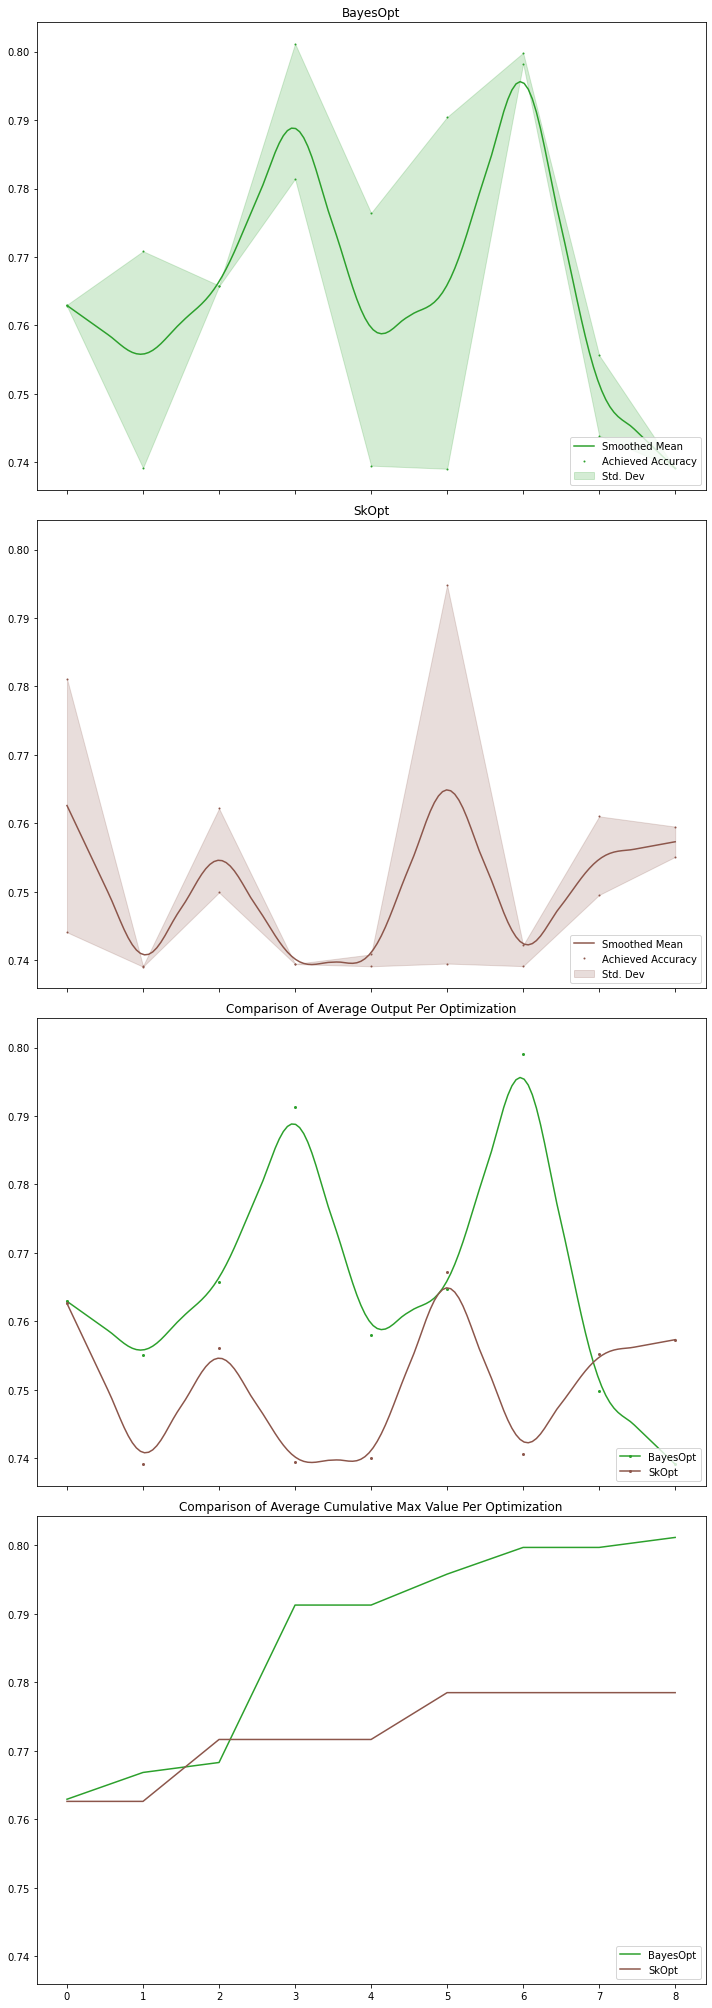

In [19]:
x = np.arange(0, n_rows, 1)
x_smoothed = np.linspace(x.min(), x.max(), 150)

fig, axes = None, None
if len(combined_dfs) == 2:
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=True, figsize=(10, 28))
elif len(combined_dfs) == 1:
    fig, axes = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(10, 28))
all_axes = {}
i = 0
for key in combined_dfs.keys():
    all_axes[key] = axes[i]
    i+=1
all_axes["All"] = axes[i]
i+=1
all_axes["Max"] = axes[i]

comb_axes = axes[i-1]
max_axes = axes[i]

colors = {
    "BayesOpt": "C2",
    "SkOpt": "C5",
}

comb_legend_handles = []
max_legend_handles = []

for name, df in combined_dfs.items():
    df = df[:n_rows]
    ymean = df["Mean"]
    ystd = df["Std"]
    ystd_up = df["Upper"]
    ystd_dn = df["Lower"]

    ax = all_axes[name]

     # Smooth the means to make it easier to read
    itp = interp1d(x, ymean, kind='linear')
    window_size, poly_order = 17, 3
    ymean_smoothed = savgol_filter(itp(x_smoothed), window_size, poly_order)

    ax.plot(x_smoothed, ymean_smoothed, '-', color=colors[name])
    ax.plot(x, df["test_accuracy"], 'o', color=colors[name], markersize=1)
    ax.fill_between(x, ystd_up, ystd_dn, alpha=0.2, color=colors[name])
    ax.set_title(name)

    mean_line = mlines.Line2D([], [], color=colors[name],  markersize=1, label='Smoothed Mean')
    points = mlines.Line2D([], [], color=colors[name], marker="o",  markersize=1, linestyle="", label='Achieved Accuracy')
    std_patch = mpatches.Patch(color=colors[name], alpha=0.2, label='Std. Dev')
    ax.legend(handles=[mean_line, points, std_patch], loc="lower right")

    comb_axes.set_title("Comparison of Average Output Per Optimization")
    comb_axes.plot(x_smoothed, ymean_smoothed, '-', color=colors[name])
    comb_axes.plot(x, ymean, 'o', color=colors[name], markersize=2)
    # comb_axes.fill_between(x, ystd_up, ystd_dn, alpha=0.2, color=colors[name])

    comb_legend_handles.append(mlines.Line2D([], [], color=colors[name], marker="o",  markersize=2, label=name))

    max_axes.set_title("Comparison of Average Cumulative Max Value Per Optimization")
    # max_axes.plot(x, ymean, 'o', color=colors[name], markersize=2)
    max_axes.plot(x, df[["test_accuracy"]].cummax().mean(axis=1), '-', color=colors[name], alpha=1.0)
    
    max_legend_handles.append(mlines.Line2D([], [], color=colors[name], label=name))


comb_axes.legend(handles=comb_legend_handles, loc="lower right")
max_axes.legend(handles=max_legend_handles, loc="lower right")

fig.tight_layout()
# fig2.tight_layout()

fig.savefig('SearchComparison.png', facecolor="white", transparent=False)